In [12]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add

In [13]:
from wmpgnn.model.gnn_model import GNN
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
# Load the configuration
config_loader = ConfigLoader("config_files/heteromp_gnn_inference.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/mp_gnn_inference.yaml", environment_prefix="DL")

In [3]:
import pandas as pd


In [12]:
!ls /home/sutclw/results2/

Final_hetero_8block_32_epochs_message_passing_BCE.csv
Final_hetero_8block_32_epochs_message_passing_BCE.pt
Final_hetero_8block_32_epochs_message_passing.csv
Final_hetero_8block_32_epochs_message_passing.pt
Final_hetero_8block_32_epochs_message_passing_pvconstraints.csv
Final_hetero_8block_32_epochs_weighted_message_passing_BCE.csv
Final_hetero_8block_32_epochs_weighted_message_passing_BCE.pt
Final_hetero_8block_32_epochs_weighted_message_passing.csv
Final_hetero_8block_32_epochs_weighted_message_passing.pt
Final_hetero_8block_32_epochs_weighted_message_passing_pvconstraints.csv


In [7]:
!ls /home/sutclw/full_graph_results/

Final_full_graph_8block_32_epochs_message_passing.csv
Final_full_graph_8block_32_epochs_message_passing.pt
Final_full_graph_8block_32_epochs_weighted_message_passing_BCE.csv
Final_full_graph_8block_32_epochs_weighted_message_passing_BCE.pt
Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_BCE.csv
Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_BCE.pt


In [14]:
import matplotlib.pyplot as plt


def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)
class Tango(object):
    scarlet_red_light = '#ef2929'
    scarlet_red = '#cc0000'
    scarlet_red_dark = '#a40000'

    aluminium_light = '#eeeeec'
    aluminium = '#d3d7cf'
    aluminium_dark = '#babdb6'

    butter_light = '#fce94f'
    butter = '#edd400'
    butter_dark = '#c4a000'

    chameleon_light = '#8ae234'
    chameleon = '#73d216'
    chameleon_dark = '#4e9a06'

    orange_light = '#fcaf3e'
    orange = '#f57900'
    orange_dark = '#ce5c00'

    chocolate_light = '#e9b96e'
    chocolate = '#c17d11'
    chocolate_dark = '#8f5902'

    sky_blue_light = '#729fcf'
    sky_blue = '#3465a4'
    sky_blue_dark = '#204a87'

    plum_light = '#ad7fa8'
    plum = '#75507b'
    plum_dark = '#5c3566'

    slate_light = '#888a85'
    slate = '#555753'
    slate_dark = '#2e3436'

init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

In [22]:
!ls /home/sutclw/results2/results2

Final_full_graph_hetero_8block_32_epochs_message_passing_onlypvs.csv
Final_full_graph_hetero_8block_32_epochs_message_passing_onlypvs.pt
Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_onlypvs.csv
Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_onlypvs.pt
Final_hetero_8block_32_epochs_message_passing_BCE_corrected.pt
Final_hetero_8block_32_epochs_message_passing_BCE.csv
Final_hetero_8block_32_epochs_message_passing_BCE.pt
Final_hetero_8block_32_epochs_message_passing.csv
Final_hetero_8block_32_epochs_message_passing.pt
Final_hetero_8block_32_epochs_message_passing_pvconstraints.csv
Final_hetero_8block_32_epochs_message_passing_pv_constraints.pt
Final_hetero_8block_32_epochs_weighted_message_passing_BCE.csv
Final_hetero_8block_32_epochs_weighted_message_passing_BCE.pt
Final_hetero_8block_32_epochs_weighted_message_passing.csv
Final_hetero_8block_32_epochs_weighted_message_passing.pt
Final_hetero_8block_32_epochs_weighted_message_passing_pvconstraints.

In [19]:
from wmpgnn.performance.reconstruction import reconstruct_decay
from wmpgnn.performance.reconstruction import particle_name
from wmpgnn.performance.reconstruction import flatten
from wmpgnn.util.functions import acc_four_class
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


class Performance:
    """ Class responsible for determining performance given a dataset and 
    a configuration for both homogeneous and heterogeneous GNNs. """

    def __init__(self, config, performance_mode=False, full_graphs = False):
        self.config_loader = config
        self.data_loader = DataHandler(config_loader, performance_mode=performance_mode)
        self.data_loader.load_data()
        self.full_graphs = full_graphs
        self.data_type = config.get("dataset.data_type")
        
        model_loader = ModelLoader(config_loader)
        self.model = model_loader.get_model()
        self.full_graphs = full_graphs
        # self.model.load_state_dict(torch.load('/home/sutclw/results/Final_model_8block_32epochs_weighted_message_passing_BCE_3Feb25.pth'))
        # self.model.eval()
        #self.model.load_state_dict(torch.load('/home/sutclw/full_graph_results/Final_full_graph_8block_32_epochs_weighted_message_passing_BCE.pt'))
        #self.model.eval()
        #self.model.load_state_dict(torch.load('/home/sutclw/results2/Final_hetero_8block_32_epochs_weighted_message_passing_BCE.pt'))
        #self.model.eval()
        #self.model.load_state_dict(torch.load('/home/sutclw/full_graph_results/Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_BCE.pt'))
        #self.model.eval()
        self.model.load_state_dict(torch.load('/home/sutclw/results2/results2/Final_hetero_8block_32_epochs_message_passing_BCE_corrected.pt'))
        self.model.eval()
#Final_hetero_8block_32_epochs_message_passing_BCE.pt
        
    def evaluate_hetero_lca_accuracy(self,prune_layer=3, bdt_pruned_data=False, batch_size=8):
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        acc_one_epoch = []
        self.model.cuda()
        for i, data in enumerate(self.dataset): 
            data.to('cuda')
            label0= data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
            answers = torch.ones_like(data[('tracks', 'to', 'tracks')].edges).cuda()
            outputs = self.model(data)
            label= data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
     
            if self.model._blocks[prune_layer].edge_prune == True:
                indices = self.model._blocks[prune_layer].edge_indices[('tracks', 'to', 'tracks')]
                index = torch.ones(label0.shape[0], dtype=bool).cuda()
                index[indices] = False
                selected_labels = label0[index]
                answers[:,1:] = 0
                answers[indices] = outputs[('tracks', 'to', 'tracks')].edges
 
            if self.model._blocks[prune_layer].edge_prune == True:
                acc_one_batch = acc_four_class(answers, label0)
            elif bdt_pruned_data:
                y_full = torch.concat([data.old_y,data[('tracks', 'to', 'tracks')].y])
                bdt_pruned_edges = torch.ones_like(data.old_y).cuda()
                bdt_pruned_edges[:,1:]=0
                edge_full = torch.concat([bdt_pruned_edges, outputs[('tracks', 'to', 'tracks')].edges])
                acc_one_batch = acc_four_class(edge_full,y_full.argmax(dim=1))
            else:
                acc_one_batch = acc_four_class(outputs[('tracks', 'to', 'tracks')].edges, label)
            acc_one_epoch.append(acc_one_batch)
        acc_one_epoch=torch.stack(acc_one_epoch)
        return acc_one_epoch.nanmean(dim=0)

    def evaluate_homog_lca_accuracy(self,prune_layer=3, bdt_pruned_data=False, batch_size=8):
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        acc_one_epoch = []
        self.model.cuda()
        
        for j, vdata in enumerate(self.dataset): 
            vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
            vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
            vdata.senders = vdata.senders - torch.min(vdata.senders)
            vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
            vdata.to('cuda')
            label0 = vdata.y.argmax(dim=1)
            answers = torch.ones_like(vdata.edges).cuda()
            
            outputs = self.model(vdata)
            vdata = outputs
            label= vdata.y.argmax(dim=1)
    
            if self.model._blocks[prune_layer]._network.edge_prune == True:
                indices= self.model._blocks[7]._network.edge_indices
                index = torch.ones(label0.shape[0], dtype=bool).cuda()
                index[indices] = False
                selected_labels = label0[index]
                answers[:,1:] = 0
                answers[indices] = outputs.edges
    
            if self.model._blocks[prune_layer]._network.edge_prune == True:
                acc_one_batch = acc_four_class(answers, label0)
            elif bdt_pruned_data:
                y_full = torch.concat([vdata.old_y, vdata.y])
                bdt_pruned_edges = torch.ones_like(vdata.old_y).cuda()
                bdt_pruned_edges[:,1:]=0
                edge_full = torch.concat([bdt_pruned_edges, outputs.edges])
                acc_one_batch = acc_four_class(edge_full,y_full.argmax(dim=1))
            else:
                acc_one_batch = acc_four_class(outputs.edges, label)
            acc_one_epoch.append(acc_one_batch)
        
        acc_one_epoch=torch.stack(acc_one_epoch)
    
        return acc_one_epoch.nanmean(dim=0)
        
    def set_edge_pruning(self, layer, cut, device='cuda'):
        if self.data_type == "homogeneous":
            self.model._blocks[layer]._network.edge_prune = True
            self.model._blocks[layer]._network.edge_weight_cut = cut
            self.model._blocks[layer]._network.prune_by_cut = True
            self.model._blocks[layer]._network.device = device
        elif self.data_type == "heterogeneous":
            self.model._blocks[layer].edge_prune = True
            self.model._blocks[layer].edge_weight_cut = cut
            self.model._blocks[layer].prune_by_cut = True
            self.model._blocks[layer].device = device
            
    def set_node_pruning(self, layer, cut, device='cuda'):
        if self.data_type == "homogeneous":
            self.model._blocks[layer]._network.node_prune = True
            self.model._blocks[layer]._network.node_weight_cut = cut
            self.model._blocks[layer]._network.prune_by_cut = True
            self.model._blocks[layer]._network.device = device
        elif self.data_type == "heterogeneous":
            self.model._blocks[layer].node_prune = True
            self.model._blocks[layer].node_weight_cut= cut
            self.model._blocks[layer].prune_by_cut = True
            self.model._blocks[layer].device = device

    def set_pruning(self, layer, cut, device='cuda'):
        self.set_edge_pruning(layer, cut, device=device)
        self.set_node_pruning(layer, cut, device=device)

    
    def lca_reco_matrix(self, graph):
        if self.data_type == "homogeneous":
            senders = graph.senders
            receivers = graph.receivers
            edges = graph["edges"]
        elif self.data_type == "heterogeneous":
            senders = graph[('tracks','to','tracks')].edge_index[0]
            receivers = graph[('tracks','to','tracks')].edge_index[1]
            edges = graph[('tracks','to','tracks')].edges
        edge_index = torch.vstack([senders,receivers])
        pd_matrix = pd.DataFrame(np.vstack(
            (edge_index[0], edge_index[1])).transpose(), columns=['senders', 'receivers'])
        pd_matrix["LCA_probs"] = list(edges.detach().numpy())
        pd_matrix["LCA_dec"] = list( np.argmax( edges.detach().numpy() , axis = -1))
        pd_matrix.set_index(['senders', 'receivers'], inplace=True)
        pd_matrix = pd_matrix.reset_index()
        pd_matrix = pd_matrix[pd_matrix['senders'] < pd_matrix['receivers']]
        reverse_order_indices = list(map(tuple, np.vstack((graph["receivers"], graph["senders"])).transpose()))
        return pd_matrix

    def lca_truth_matrix(self, graph):
        if self.data_type == "homogeneous":
            senders = graph.init_senders
            receivers = graph.init_receivers
            init_y = graph["init_y"]
        elif self.data_type == "heterogeneous":
            senders = graph.init_senders
            receivers = graph.init_receivers
            init_y = graph["init_y"]
            
        truth_lca = pd.DataFrame(np.column_stack((senders, receivers)), columns=['senders', 'receivers'])
        truth_lca['LCA_dec'] = np.reshape(
        np.argmax(
            np.reshape(init_y, (init_y.shape[0], 4)), axis=-1),
        (-1,))
        truth_lca = truth_lca[truth_lca['senders'] < truth_lca['receivers']]
        truth_lca['LCA_id_label'] = list(map(particle_name, graph['init_moth_ids'].numpy()))
        truth_lca['TrueFullChainLCA'] = graph['lca_chain']
        return truth_lca

    def init_reco_dataframes(self):
        self.signal_df = pd.DataFrame(columns=['EventNumber', 'NumParticlesInEvent', 'NumSignalParticles', 'PerfectSignalReconstruction', 'AllParticles','PerfectReco',
                                 'NoneIso', 'PartReco', 'NotFound'])
        self.signal_df = self.signal_df.astype({'EventNumber': np.int32, 'NumParticlesInEvent': np.int32, 'NumSignalParticles': np.int32, 'PerfectSignalReconstruction': np.int32,
                              'AllParticles': np.int32,'PerfectReco': np.int32,
                                 'NoneIso': np.int32, 'PartReco': np.int32, 'NotFound': np.int32})



        self.event_df = pd.DataFrame(columns=['EventNumber', 'NumParticlesInEvent', 'NumParticlesFromHeavyHadronInEvent', 'NumBackgroundParticlesInEvent', 'NumSelectedParticlesInEvent', 'NumSelectedParticlesFromHeavyHadronInEvent',
                                     'NumSelectedParticlesFromHeavyHadronInEventNPOnly', 'NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly', 'NumSelectedBackgroundParticlesInEvent', 'NumTruthClustersGen1', 'NumTruthClustersGen2',
                                     'NumTruthClustersGen3', 'NumTruthClustersGen4', 'NumRecoClustersGen1', 'NumRecoClustersGen2', 'NumRecoClustersGen3', 'NumRecoClustersGen4', 'MaxTruthFullChainDepthInEvent',
                                     'EfficiencyParticlesFromHeavyHadronInEvent', 'EfficiencyBackgroundParticlesInEvent', 'BackgroundRejectionPowerInEvent', 'PerfectEventReconstruction', 'TimeNodeFiltering', 'TimeEdgeFiltering',
                                     'TimeLCAReconstruction', 'TimeSequence', 'NumTrueSignalsInEvent', 'NumRecoSignalsInEvent','TimeModel','TimeReco','TimeTruth'])
        
    def evaluate_pv_association(self, batch_size=8, b_tracks = True):
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        running_acc = 0
        self.model.cuda()
        for i, data in enumerate(self.dataset): 
            data.to('cuda')

            outputs = self.model(data)
            data = outputs
            PVlabel= torch.tensor(data[('tracks', 'to', 'pvs')].y,dtype=torch.float32)

            if b_tracks:
                tracks =data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:,0]==0]
            else:
                tracks =data[('tracks', 'to', 'tracks')].edge_index[0]
            unique_tracks = torch.unique(tracks)
            correctly_associated = 0
            
            for i in  unique_tracks:
                index = (data[('tracks', 'to', 'pvs')].edge_index[0]==i)
                pv_associated = (torch.argmax(self.model._blocks[-1].edge_weights[('tracks', 'to', 'pvs')][index])==torch.argmax(data[('tracks', 'to', 'pvs')].y[index]))
                correctly_associated += int(pv_associated.item())
        
            running_acc+=correctly_associated/unique_tracks.shape[0]
        acc = running_acc/len(self.dataset)
        return acc

    def evaluate_homog_track_pruning_performance(self, layers=[0,1,2,7], batch_size=8, edge_pruning=True): 
        trues = []
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        self.model.cuda()
        preds = {}
        for layer in layers:
            preds[layer] = []
        for j, data in enumerate(self.dataset): 
            
            data['graph_globals'] = data['graph_globals'].unsqueeze(1)
            data.receivers = data.receivers - torch.min(data.receivers)
            data.senders = data.senders - torch.min(data.senders)
            data.edgepos = data.edgepos - torch.min(data.edgepos)
            data.to('cuda')
            outputs = self.model(data)
    
            label= data.y.argmax(dim=1)
            num_nodes=data.nodes.shape[0]
            out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
            node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            if edge_pruning:
                trues.append( 1*(outputs.cpu().y.detach().numpy()[:,0] == 0 ) ) 
                for layer in layers:
                    preds[layer].append(self.model._blocks[layer]._network.edge_weights.cpu().detach().numpy())
            else:
                trues.append(ynodes.cpu().detach().numpy()) 
                for layer in layers:
                    preds[layer].append(self.model._blocks[layer]._network.node_weights.cpu().detach().numpy())
        true = np.concatenate(trues)
        pred = [np.concatenate(preds[i]) for i in layers]
        names = [f"Layer {i}" for i in layers]

        if edge_pruning:
            self.plot_roc_curve(true, pred, names, file_name="hetero_edge_pruning_roc", title="Edge")
        else:
            self.plot_roc_curve(true, pred, names, file_name="hetero_node_pruning_roc", title="Node")      
        
    def evaluate_hetero_track_pruning_performance(self, layers=[0,1,2,7], batch_size=8, edge_pruning=True):
        trues = []
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        self.model.cuda()
        preds = {}
        for layer in layers:
            preds[layer] = []
        for i, data in enumerate(self.dataset): 
            data.to('cuda')
            outputs = self.model(data)
            data = outputs
            label= data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
        
            num_nodes=data['tracks'].x.shape[0]
            out = data[('tracks', 'to', 'tracks')].edges.new_zeros(num_nodes, data[('tracks', 'to', 'tracks')].y.shape[1])
            node_sum = scatter_add(data[('tracks', 'to', 'tracks')].y,data[('tracks', 'to', 'tracks')].edge_index[0],out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            yBCE = 1.*(data[('tracks', 'to', 'tracks')].y[:,0]==0).unsqueeze(1)
        
            if edge_pruning:
                trues.append(yBCE.cpu().detach().numpy()) 
                for layer in layers:
                    preds[layer].append(self.model._blocks[layer].edge_weights[('tracks','to','tracks')].cpu().detach().numpy())
            else:
                trues.append(ynodes.cpu().detach().numpy()) 
                for layer in layers:
                    preds[layer].append(sel.model._blocks[layer].node_weights[('tracks','to','tracks')].cpu().detach().numpy())
        true = np.concatenate(trues)
        pred = [np.concatenate(preds[i]) for i in layers]
        names = [f"Layer {i}" for i in layers]

        if edge_pruning:
            self.plot_roc_curve(true, pred, names, file_name="hetero_edge_pruning_roc", title="Edge")
        else:
            self.plot_roc_curve(true, pred, names, file_name="hetero_node_pruning_roc", title="Node")            
    
    
    def plot_roc_curve(self, y_true, y_scores, names, file_name="test_edge_pruning_roc", title="Edge"):
        plt.figure(figsize=(8, 6))
    
        line_styles = ["dashdot","dashed","dotted","--","solid"]
        for i in range(0,len(y_scores)):
            name = names[i]
            y_score = y_scores[i]
            line_style = line_styles[i]
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = roc_auc_score(y_true, y_score)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})',linestyle=line_style)
            print(auc_score)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{title} Pruning Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.grid()
        plt.savefig(file_name + ".png", dpi=200)
        plt.savefig(file_name + ".pdf")
        plt.show()
    

    
    def evaluate_reco_performance(self, event_max = -1, plot_perfect_decaychains=2):
            # should eventually include BDT timing and perf. in filtering when caching dataset
            self.dataset = self.data_loader.get_test_dataloader(batch_size=1)
            self.init_reco_dataframes()
            time_node_filtering = 0
            time_edge_filtering = 0 
            time_LCA_reconstruction = 0
            number_of_selected_particles_from_heavy_hadron_NPonly = 0 
            number_of_selected_particles_from_heavy_hadron_NPandEPonly = 0 
            compute_performance = 1

            j = 0
            event = 0
            event=0
            count=0
            count2=0
            count3= 0 
            time_model = 0
            time_reco = 0
            for batch_i, vdata in enumerate(self.dataset): 
                if batch_i == event_max:
                    print(f"Event loop for reconstruction ending at event max {event_max}")
                    break
                if event%100 == 0:
                    print(event)
                Bparts = float(torch.sum(torch.argmax(vdata.init_y,-1)>0))
                if Bparts < 1:
                    continue
                if self.data_type == "homogeneous":
                    vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
                    vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
                    vdata.senders = vdata.senders - torch.min(vdata.senders)
                    vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
                
                count3+=1

                vdata.cuda()
                vdata_copy = vdata.clone()
                self.model.cuda()
                self.set_pruning(7,0.1)
                try:
                    start_time = time.time()
                    gout = self.model(vdata)
                    end_time = time.time()
                    time_model = end_time-start_time
                except:
                    print("Pruning looser")
                    self.set_pruning(7,0.05)
                    try:
                        start_time = time.time()
                        gout = self.model(vdata_copy)
                        end_time = time.time()
                        time_model = end_time-start_time
                    except:
                        print("Exception occurred")
                        continue
                self.model.cpu()
                gout.cpu()
                vdata.cpu()
                if self.data_type == "homogeneous":
                    Bparts_after = float(torch.sum(torch.argmax(vdata.y,-1)>0))
                elif self.data_type == "heterogeneous":
                    Bparts_after = float(torch.sum(torch.argmax(vdata[('tracks','to','tracks')].y,-1)>0))
                if Bparts_after < Bparts:
                    print("Bparts lost, before had ", Bparts, " and now ", Bparts_after )

                start_time = time.time()
                reco_LCA = self.lca_reco_matrix(gout)
                particle_keys = list(vdata["final_keys"].numpy())
                
                reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
                    reco_LCA, particle_keys)
                end_time = time.time()
                time_reco = end_time-start_time
                start_time = time.time()
                true_LCA = self.lca_truth_matrix(vdata)
                particle_keys = list(vdata["init_keys"].numpy())
                particle_ids =  list(map(particle_name, vdata['init_partids'].numpy()))
                truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
                    true_LCA, particle_keys,particle_ids=particle_ids,truth_level_simulation=1)
                end_time = time.time()
                time_truth = end_time-start_time
                compute_performance = 1
                if compute_performance == 1:
                    time_node_filtering = 0
                    time_edge_filtering = 0 
                    time_LCA_reconstruction = 0
                    total_number_of_particles = len(particle_keys)
                    number_of_selected_particles_from_heavy_hadron_NPonly = 0 
                    number_of_selected_particles_from_heavy_hadron_NPandEPonly = 0 
                    #f truth_cluster_dict == {}:
                    #    count += 1
                    if truth_cluster_dict != {}:
                        count+=1
                        # Compute performance metrics
                        particles_from_heavy_hadron = flatten([truth_cluster_dict[tc_firstkey]['node_keys'] for tc_firstkey in truth_cluster_dict.keys()])
                        number_of_particles_from_heavy_hadron = len(particles_from_heavy_hadron)
                        number_of_selected_particles_from_heavy_hadron_NPonly = number_of_particles_from_heavy_hadron
                        number_of_selected_particles_from_heavy_hadron_NPandEPonly = number_of_particles_from_heavy_hadron
                        number_of_background_particles = total_number_of_particles - number_of_particles_from_heavy_hadron
                        if reco_cluster_dict != {}:
                            selected_particles = flatten([reco_cluster_dict[tc_firstkey]['node_keys'] for tc_firstkey in reco_cluster_dict.keys()])
                            number_of_selected_particles = len(selected_particles)
                            number_of_selected_particles_from_heavy_hadron = len(list(set(selected_particles).intersection(particles_from_heavy_hadron)))
                            number_of_selected_background_particles = number_of_selected_particles - number_of_selected_particles_from_heavy_hadron
                        else:
                            number_of_selected_particles = 0
                            number_of_selected_particles_from_heavy_hadron = 0
                            number_of_selected_background_particles = 0
                
                        perfect_event_reconstruction = 1
                        if number_of_selected_background_particles > 0:
                            perfect_event_reconstruction = 0
               
            
                        for tc_firstkey in truth_cluster_dict.keys():
                            number_of_signal_particles = len(truth_cluster_dict[tc_firstkey]['node_keys'])
                            perfect_signal_reconstruction = 1
                            if reco_cluster_dict == {}:
                                perfect_signal_reconstruction = 0
                            else:
                                if tc_firstkey not in reco_cluster_dict.keys():
                                    perfect_signal_reconstruction = 0
                                else:
                                    if reco_cluster_dict[tc_firstkey]['node_keys'] != truth_cluster_dict[tc_firstkey]['node_keys'] or reco_cluster_dict[tc_firstkey]['LCA_values'] != truth_cluster_dict[tc_firstkey]['LCA_values']:
                                        perfect_signal_reconstruction = 0
                            perfect_event_reconstruction *= perfect_signal_reconstruction
            
                            true_cluster = truth_cluster_dict[tc_firstkey]
                            perfect_reco = 0
                            all_particles = 0
                            none_iso = 0
                            part_reco = 0
                            none_associated = 0
                            for cluster in reco_cluster_dict.values():
                                true_in_reco = np.sum( np.isin(true_cluster['node_keys'],cluster['node_keys']))/len(true_cluster['node_keys'])
                                #reco_in_true = np.sum( np.isin(cluster['node_keys'],true_cluster['node_keys']))/len(true_cluster['node_keys'])
                                #print(val)
                                if cluster['node_keys'] == true_cluster['node_keys']:
                                    all_particles = 1
                                    if cluster['LCA_values'] == true_cluster['LCA_values']:
                                        perfect_reco = 1
                                    break
                                elif true_in_reco == 1 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
                                    none_iso = 1
                                elif true_in_reco >= 0.2 and true_in_reco < 1:
                                    part_reco = 1
                                #elif val >= 0.2 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
                                #    none_iso = 1
                            if all_particles == 1:
                                none_iso = 0
                                part_reco = 0
                            if all_particles == 0 and none_iso == 0 and part_reco == 0:
                                none_associated = 1
                            self.signal_df = self.signal_df._append({'EventNumber' : event,
                                                          'NumParticlesInEvent': total_number_of_particles,
                                                          'NumSignalParticles': number_of_signal_particles,
                                                          'PerfectSignalReconstruction': perfect_signal_reconstruction,
                                                          'AllParticles': all_particles,
                                                          'PerfectReco': perfect_reco,
                                                          'NoneIso' : none_iso,
                                                          'PartReco' : part_reco,
                                                          'NotFound' : none_associated},
                                                       ignore_index=True)    
                            count2+=1
                            if perfect_signal_reconstruction and plot_perfect_decaychains > 0:
                                plt.clf()
                                fix, axs = plt.subplots(2, figsize=(10, 10))
                                axs[0].set_title('Reco trees in event',
                                                 fontweight='bold', fontsize=14)
                                particle_keys = list(vdata["final_keys"].numpy())
                                reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
                                    reco_LCA, particle_keys,  axs[0])
                                axs[1].set_title('Truth-level trees in event',
                                                 fontweight='bold', fontsize=14)
                                particle_keys = list(vdata["init_keys"].numpy())
                                particle_ids =  list(map(particle_name, vdata['init_partids'].numpy()))
                                truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
                                    true_LCA, particle_keys, axs[1], particle_ids=particle_ids, truth_level_simulation=1)
                                #plt.show()
                                plt.savefig(f"perfect_reco_decay_chain_{plot_perfect_decaychains}.png")
                                plot_perfect_decaychains = plot_perfect_decaychains -  1
                            
                        event+=1
                        self.event_df = self.event_df._append({'EventNumber': event,
                                                        'NumParticlesInEvent': total_number_of_particles,
                                                        'NumParticlesFromHeavyHadronInEvent': number_of_particles_from_heavy_hadron,
                                                        'NumBackgroundParticlesInEvent': number_of_background_particles,
                                                        'NumSelectedParticlesInEvent': number_of_selected_particles,
                                                        'NumSelectedParticlesFromHeavyHadronInEvent': number_of_selected_particles_from_heavy_hadron,
                                                        'NumSelectedParticlesFromHeavyHadronInEventNPOnly': number_of_selected_particles_from_heavy_hadron_NPonly,
                                                        'NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly': number_of_selected_particles_from_heavy_hadron_NPandEPonly,
                                                        'NumSelectedBackgroundParticlesInEvent': number_of_selected_background_particles,
                                                        'NumTruthClustersGen1': truth_num_clusters_per_order[0],
                                                        'NumTruthClustersGen2': truth_num_clusters_per_order[1],
                                                        'NumTruthClustersGen3': truth_num_clusters_per_order[2],
                                                        'NumTruthClustersGen4': truth_num_clusters_per_order[3],
                                                        'NumRecoClustersGen1': reco_num_clusters_per_order[0],
                                                        'NumRecoClustersGen2': reco_num_clusters_per_order[1],
                                                        'NumRecoClustersGen3': reco_num_clusters_per_order[2],
                                                        'NumRecoClustersGen4': reco_num_clusters_per_order[3],
                                                        'MaxTruthFullChainDepthInEvent': max_full_chain_depth_in_event,
                                                        'EfficiencyParticlesFromHeavyHadronInEvent': float(number_of_selected_particles_from_heavy_hadron) / number_of_particles_from_heavy_hadron,
                                                        'EfficiencyBackgroundParticlesInEvent': float(number_of_selected_background_particles) / number_of_background_particles,
                                                        'BackgroundRejectionPowerInEvent': 1. - float(number_of_selected_background_particles) / number_of_background_particles,
                                                        'PerfectEventReconstruction': perfect_event_reconstruction,
                                                        'TimeNodeFiltering': time_node_filtering,
                                                        'TimeEdgeFiltering': time_edge_filtering,
                                                        'TimeLCAReconstruction': time_LCA_reconstruction,
                                                        'TimeSequence': time_node_filtering + time_edge_filtering + time_LCA_reconstruction,
                                                        'NumTrueSignalsInEvent': len(truth_cluster_dict.keys()),
                                                        'NumRecoSignalsInEvent': len(reco_cluster_dict.keys()),
                                                        'TimeModel' : time_model,
                                                        'TimeReco': time_reco,
                                                        'TimeTruth': time_truth},
                                                       ignore_index=True) 
        

In [20]:
perf = Performance(config_loader,performance_mode=True,full_graphs=False)

/tmp/ipykernel_14945/33057257.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('/home/sutclw/results2/results2/Final_hetero_8block_

0


/tmp/ipykernel_14945/33057257.py:505: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
No particles found.
0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
No particles found.
0
Bparts lost, before had  56.0  and now  42.0
Bparts lost, before had  42.0  and now  14.0
100
No particles found.
0
Bparts lost, before had  40.0  and now  30.0
Bparts lost, before had  54.0  and now  42.0
Bparts lost, before had  18.0  and now  14.0
No particles found.
0
Bparts lost, before had  50.0  and now  22.0
Bparts lost, before had  66.0  and now  54.0
Bparts lost, before had  32.0  and now  22.0
No particles found.
0
Bparts lost, before had  50.0  and now  40.0
Bparts lost, before had  2.0  and now  0.0
No particles found.
0
Bparts lost, before had  12.0  and now  8.0
No particles found.
0
200
No particles found.
0
Bparts lost, before had  30.0  and now  28.0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  26.0  and now  24.0
Bparts lost, be

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

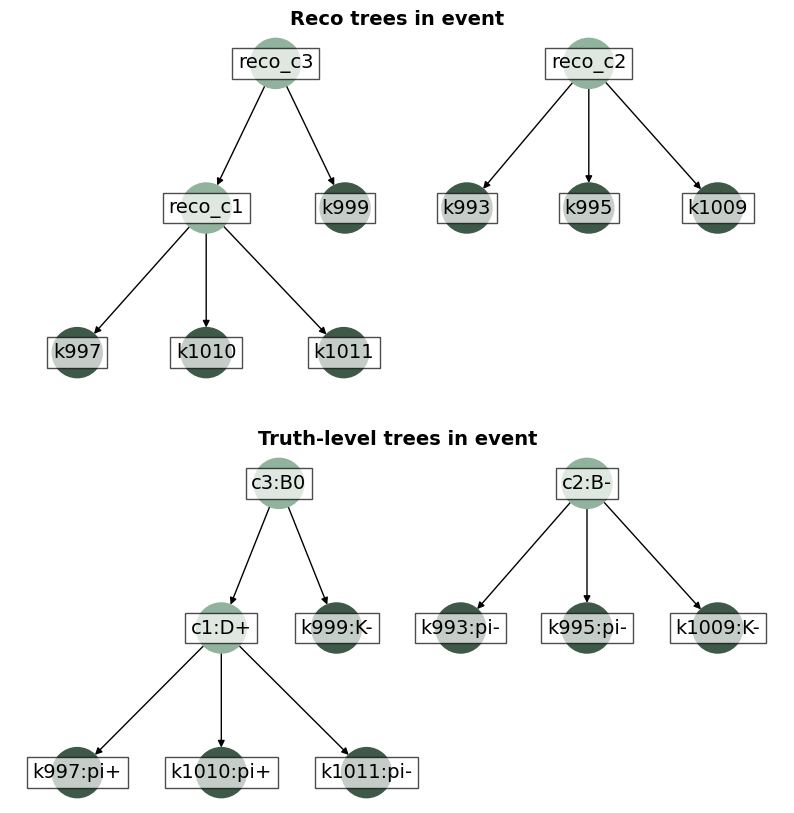

In [21]:
perf.evaluate_reco_performance(event_max=2000, plot_perfect_decaychains=10)

In [12]:
#acc = perf.evaluate_homog_lca_accuracy(bdt_pruned_data=True)

In [11]:
acc

tensor([0.9972, 0.7814, 0.5410, 0.7729])

In [13]:
#perf.evaluate_homog_track_pruning_performance()

In [14]:
acc = perf.evaluate_hetero_lca_accuracy(bdt_pruned_data=True)

In [15]:
acc

tensor([0.9974, 0.7866, 0.5367, 0.7740])

In [16]:
acc = perf.evaluate_hetero_lca_accuracy()

In [17]:
acc

tensor([0.9857, 0.8000, 0.5540, 0.7999])

In [ ]:
perf.evaluate_pv_association(b_tracks=False)

In [33]:
perf.evaluate_pv_association(b_tracks=False)

/tmp/ipykernel_6411/1321471939.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel= torch.tensor(data[('tracks', 'to', 'pvs')].y,dtype=torch.float32)


0.9987598693207513

In [21]:
perf.set_edge_pruning(7, 0.15)

In [9]:
acc = perf.evaluate_hetero_lca_accuracy(bdt_pruned_data=True)

In [11]:
acc = perf.evaluate_hetero_lca_accuracy()

In [12]:
acc

tensor([0.9857, 0.8000, 0.5540, 0.7999])

In [10]:
acc

tensor([0.9978, 0.3962, 0.2724, 0.3918])

In [13]:
perf.evaluate_reco_performance()

0


/tmp/ipykernel_32664/3583824070.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
300
No particles found.
0
400
No particles found.
0
500
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
900
1000
1100
1100
No particles found.
0
1200
No particles found.
0
No particles found.
0
No particles found.
0
1300
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1400
1500
No particles found.
0
No particles found.
0
1600
No particles found.
0
No particles found.
0
No particles found.
0
1700
No particles found.
0
1800
1900
No particles found.
0
2000
2100
2200
No particles found.
0
2300


KeyboardInterrupt: 

In [26]:
len(perf.signal_df)

234

In [23]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.21951219512195122

In [9]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.18686073957513769

In [25]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.2777777777777778

In [10]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.24779874213836478

In [24]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.4893784421715185

In [10]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.37844217151848936

In [11]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [12]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [13]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.24779874213836478

In [14]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [15]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [16]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.24779874213836478

In [73]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.295764788239412

In [17]:
len(perf.signal_df.query('NoneIso == 1'))/len(perf.signal_df)

0.33635220125786164

In [11]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.0959874114870181

In [25]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1125098347757671

In [26]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1125098347757671

In [18]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1119496855345912

In [39]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.10763520678685047

In [60]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.027328299172959366

In [19]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.033962264150943396

In [82]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.029605263157894735

In [17]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.03228754188242461

# To do

* check full graph dataset for comparison
* get heterogeneous running for reco
* reco with cpu or gpu 
* get lca accuracy with / without pruning, full graph or bdt pruned
* roc curves for layer weights and histogram of distributions
* pv association